In [1]:
import pandas as pd
import numpy as np
import torchvision
import tensorflow
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns

cpu


C:\Users\Andris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Andris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.1307
Epoch [2/5], Loss: 0.0748
Epoch [3/5], Loss: 0.1179
Epoch [4/5], Loss: 0.0450
Epoch [5/5], Loss: 0.0424
Accuracy: 98.09%
Precision: 0.9812587375469806
Recall: 0.9809


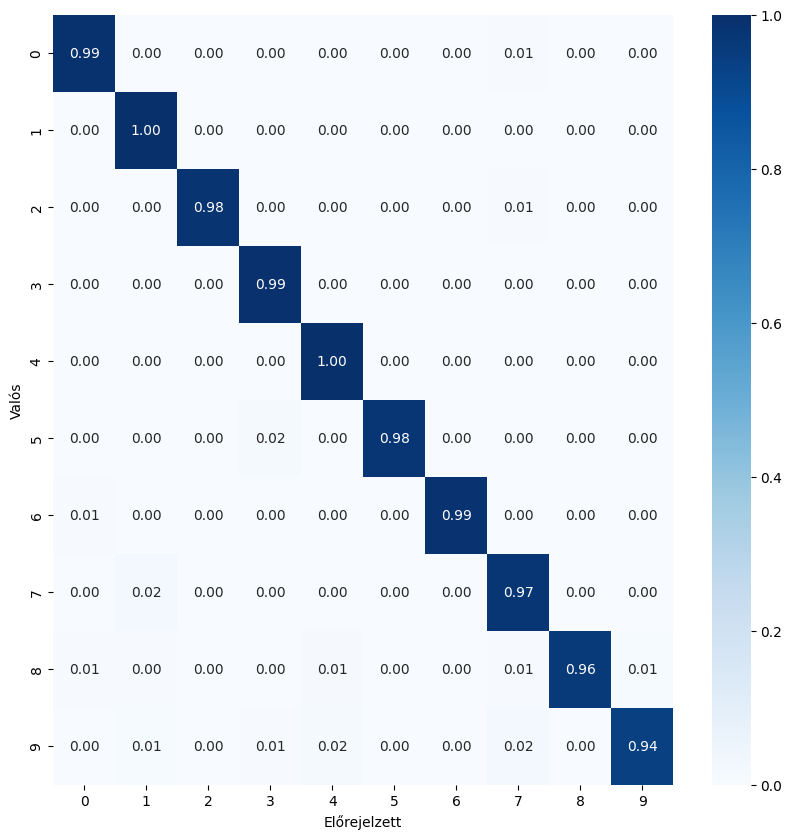

Leginkább összekevert: 9 és 7
Konfúzió mértéke: 0.023785926660059464


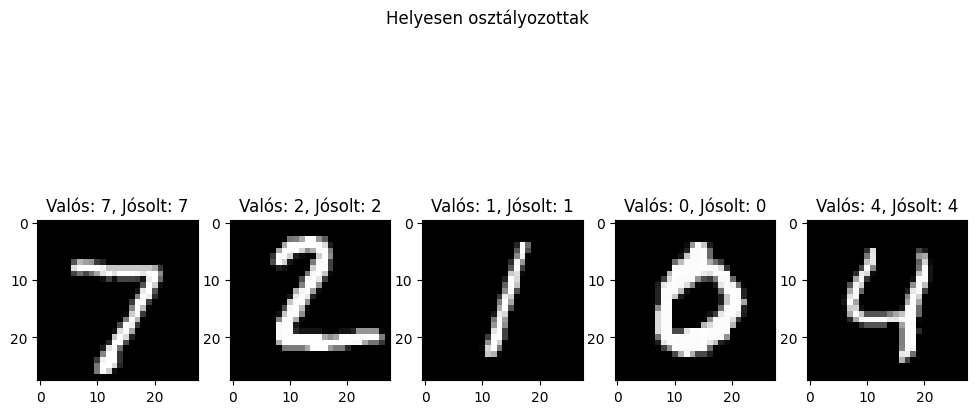

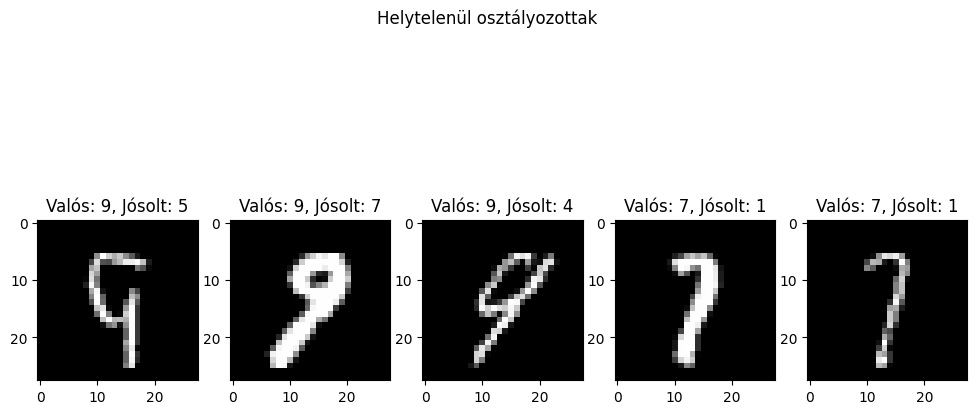

In [2]:
#modelfut(epochs, optimizer2)


#modell futtatása tanítóadatokon
epochs=5
trlosses=[]


#transzformálás+train-test
transform_train = transforms.Compose([

    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(), transforms.Resize((28, 28)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(), transforms.Resize((28, 28)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
#adatok betöltése+loading
train_data= torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
train_load = DataLoader(train_data, batch_size=64, shuffle=True)

testdata = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testload = DataLoader(testdata, batch_size=64, shuffle=False)

#min fut
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cu')
else:
    device = torch.device('cpu')
    print('cpu')

model = resnet50(pretrained=True)



model.fc = nn.Linear(2048, 10)
model=model.to(device)
#feldolgozás
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model.parameters(), lr=0.001)
optimizer2 = optim.RMSprop(model.parameters(), lr=0.001) #kipróbálom ezzel is, mert találtam egy tanulmányt, ami szerint jobb eredményekhez vezethet
#fontos tulajdonságok kigyűjtése
optimizer=optimizer1
for x in range(epochs):
    model.train()
    runningloss=0.0
    for inputs, labels in train_load:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningloss=runningloss+loss.item()

    avg_loss = runningloss / len(train_load)
    trlosses.append(avg_loss)
    print(f"Epoch [{x + 1}/{epochs}], Loss: {avg_loss:.4f}")



#modell futtatása tesztadatokon
model.eval()
correct = 0
total = 0
preds = []
labelslist = []
helyes = []
nem = []

with torch.no_grad(): 
    for inputs, labels in testload:
        inputs, labels = inputs.to(device), labels.to(device)
        
     
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) 
        
        for i in range(len(labels)):
            if labels[i] == predicted[i]:
                helyes.append((inputs[i].cpu(), labels[i].item(), predicted[i].item()))
            else:
                nem.append((inputs[i].cpu(), labels[i].item(), predicted[i].item()))
        

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

        preds.extend(predicted.cpu().numpy())
        labelslist.extend(labels.cpu().numpy())


accuracy = 100 * correct / total
print("Accuracy: " + str(accuracy) + "%")

precision = precision_score(labelslist, preds, average='weighted')
recall = recall_score(labelslist, preds, average='weighted')
print("Precision: " + str(precision))
print("Recall: " + str(recall))

#5. viz
konf=confusion_matrix(labelslist, preds)
def normalizalo(konf):
    konf=konf/konf.sum(axis=1, keepdims=True)
    return konf

konf=normalizalo(konf)
plt.figure(figsize=(10, 10))
sns.heatmap(konf, annot=True, cmap='Blues', fmt='.2f', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Előrejelzett')
plt.ylabel('Valós')
plt.show()

konflist=pd.DataFrame()
xs=[]
ys=[]
konfs=[]
#leginkább összekevert
for x in range(10):
    for y in range(10):
        if x!=y:
            xs.append(x)
            ys.append(y)
            konfs.append(konf[x, y])
konflist["x"]=xs
konflist["y"]=ys
konflist["konf"]=konfs

max=0
i=0
for x in konflist["konf"]:
    if i==0 or x>max:
        max=x
        maxi=i
    i=i+1
print("Leginkább összekevert: "+str(xs[maxi])+" és "+ str(ys[maxi]))
print("Konfúzió mértéke: "+str(max))


#6.: 5-5 db jó és rossz kép
correct_images, correct_labels, correct_preds = zip(*helyes[:5])
misclass_images, misclass_labels, misclass_preds = zip(*nem[:5])

def show_images(images, labels, cim, preds,n):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy() 
        img = (img - img.min()) / (img.max() - img.min()) 
        plt.imshow(img)
        plt.title(f"Valós: {labels[i]}, Jósolt: {preds[i]}")
    plt.suptitle(cim)
    plt.show()

show_images(correct_images, correct_labels, "Helyesen osztályozottak", correct_preds, 5)
show_images(misclass_images, misclass_labels, "Helytelenül osztályozottak", misclass_preds, 5)



